In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()

file_list = glob.glob(os.path.join(os.getcwd(), "/Users/felipesick/Desktop/Mallet_implementation/text", "*.txt"))

corpus = []
files = []

for file_path in file_list:
    with open(file_path, encoding="latin-1") as f_input:
        corpus.append(f_input.read())
        files.append(''.join([n for n in os.path.basename(file_path)]))

df = pd.DataFrame({'file':files, 'text':corpus})

/Users/felipesick/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df.head()

,file,text
0,39370-11In-8267700E1718303650K-Gl-1.txt,ÿþ    C o r p o r a t e R e g i s t e r . c o ...
1,45271-12In-13354945D11507707116I-Gl.txt,ÿþ          S K F   C a r e \n A n n u a l   R...
2,41504-11In-10168480J1805590016R-Gl.txt,ÿþ2 0 1 0 \n A n n u a l   R e p o r t \n     ...
3,36935-11In-8088765I5803374940E-Gl.txt,A year of delivering TomorrowÕs Answers To...
4,36706-11In-9653678F1098427050O-Gl.txt,ÿþa n n u a l   r e p o r t   2 0 1 0 \n      ...


In [3]:
df2 = pd.read_excel (r'/Users/felipesick/Desktop/Mallet_implementation/articles_mallet.xlsx')
df2.head()

,Country,Industry,Year,file
0,The Netherlands,Financials,2015,71732-15In-16139700N1766185304U-Gl.txt
1,Austria,Consumer Goods,2015,74028-15In-17396580N5484586464F-Gl.txt
2,The Netherlands,Basic Materials,2015,70954-15In-17525638H15128811880Q-Gl.txt
3,France,Industrials,2015,73414-15In-16958634K13958791132V-Gl.txt
4,The Netherlands,Basic Materials,2015,71860-15In-16240360C22862905740J-Gl.txt


In [4]:
pd.merge(df, df2, on="file")

,file,text,Country,Industry,Year


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    108 non-null    object
 1   text    108 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [6]:
import nltk 
nltk.download('stopwords')
import pyLDAvis
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipesick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/felipesick/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/felipesick/miniforge3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [7]:
data = list(df.text)

In [8]:
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [10]:
data_ready = process_words(data)

In [11]:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 11847


In [12]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [13]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/Users/felipesick/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


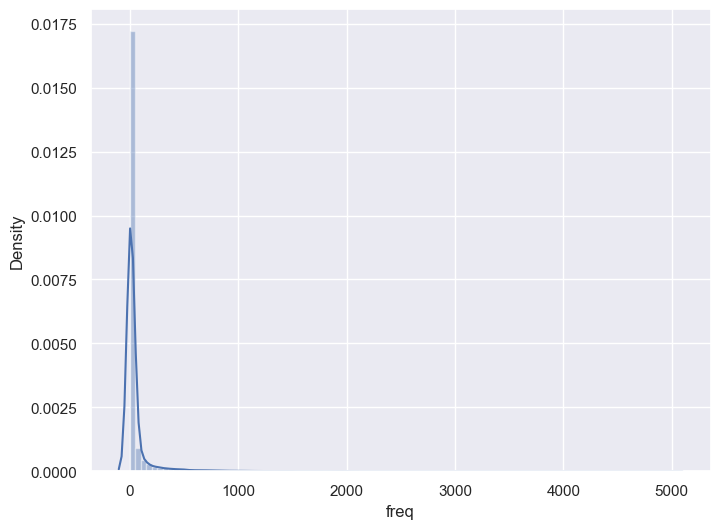

In [14]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);


In [15]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
year,4995
share,4749
financial,4661
company,4594
report,4173
business,4155
group,3798
asset,3764
market,3607
management,3538


In [16]:
extension = dict_df[dict_df.freq>1500].index.tolist()

In [17]:
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

In [18]:
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 11847


In [19]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 2340


In [20]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [21]:
mallet_path = "/Users/felipesick/Desktop/Mallet_implementation/mallet-2.0.8/bin/mallet"

In [2]:
import os
import sys
import gensim
import pyLDAvis
import pyLDAvis.gensim

from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaMallet

print('Python Version: %s' % (sys.version))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/felipesick/miniforge3/lib/python3.9/site-packages/gensim/matutils.py", line 1353, in <module>
    from gensim.corpora._mmreader import MmReader  # noqa: F401
  File "gensim/corpora/_mmreader.pyx", line 10, in init gensim.corpora._mmreader
ImportError: cannot import name utils

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/felipesick/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/j_/1y_1_njd2z7dkt41cjdjwcp80000gn/T/ipykernel_16234/3693506924.py", line 3, in <cell line: 3>
    import gensim
  File "/Users/felipesick/miniforge3/lib/python3.9/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
  File "/Users/felipesick/miniforge3/lib/python

In [22]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=50, id2word=id2word)

AttributeError: module 'gensim.models' has no attribute 'wrappers'